# Understanding Real Estate scenario in Mumbai

Mumbai is a megapolice with plethora of opportunities. This attracts large inflow of job aspirants to the city. Howere, due to the city being a linear coastel city, the housing costs have skyrocketed in the last decade. With mating data from real estate websites and foursquare venues data, we will try to understand characteristics of the neighbourhoods and its relation to pricing.

In [1]:
import pandas as pd
import numpy as np
import geocoder
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
stations = pd.read_csv('https://raw.githubusercontent.com/SudoKC/Coursera_Capstone/main/MumbaiRailStations.csv')
stations.head()

,Latitude,Longitude,Station_Name
0,19.081522,72.841756,Santacruz
1,19.069658,72.839894,Khar Road
2,19.016855,72.859193,Wadala Road
3,18.996332,72.830860,Lower Parel
4,18.934487,72.827307,Churchgate


In [3]:
# No. of stations
print(f'We have dataset for {stations.shape[0]} stations in Mumbai')


We have dataset for 56 stations in Mumbai


In [4]:
from geopy.geocoders import Nominatim

address = 'Mumbai, Maharashtra, India'

geolocator = Nominatim(user_agent="M_Transit_Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai City are 19.0759899, 72.8773928.


## Showcasing map with suburban rail stations in Mumbai

In [5]:
# create map of Mumbai using latitude and longitude values
Map_Mumbai = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add station markers to map
for lat, long, Railstation in zip(stations['Latitude'], stations['Longitude'], stations['Station_Name']):
    label = '{}'.format(Railstation)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='maroon',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Map_Mumbai)  
    
Map_Mumbai

In [6]:
CLIENT_ID = 'QPYKSND0EG3FPWWO2EPQOYR0WPX1TRFFXV2M52FORLRJTPYT' # your Foursquare ID
CLIENT_SECRET = 'SLMX4FRF12YQDSQ55PN15DBGF55LO2USDELBWGM3H5L3D25A' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QPYKSND0EG3FPWWO2EPQOYR0WPX1TRFFXV2M52FORLRJTPYT
CLIENT_SECRET:SLMX4FRF12YQDSQ55PN15DBGF55LO2USDELBWGM3H5L3D25A


## Defining function to fetch, clean and collate venues data for each of the stations

In [7]:
import json
import requests

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
lt=19.0815223
lg=72.8417565
radius =1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lt, 
            lg, 
            radius, 
            LIMIT)
result = requests.get(url).json()["response"]['groups'][0]['items']
result

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4cda8dc7b34e60fc88e64399',
   'name': 'Sandwizzaa',
   'location': {'address': 'Kanu Desai Rd, Station Rd, Santacruz (W)',
    'lat': 19.08070030358886,
    'lng': 72.84041405733342,
    'labeledLatLngs': [{'label': 'display',
      'lat': 19.08070030358886,
      'lng': 72.84041405733342}],
    'distance': 168,
    'postalCode': '400054',
    'cc': 'IN',
    'city': 'Mumbai',
    'state': 'Mahārāshtra',
    'country': 'India',
    'formattedAddress': ['Kanu Desai Rd, Station Rd, Santacruz (W)',
     'Mumbai 400054',
     'Mahārāshtra',
     'India']},
   'categories': [{'id': '4bf58dd8d48988d1c5941735',
     'name': 'Sandwich Place',
     'pluralName': 'Sandwich Places',
     'shortName': 'Sandwiches',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
      'suffix': '.png'},
     'primary': Tr

In [10]:
from pandas.io.json import json_normalize
venues = result
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(100)

<ipython-input-10-2034cb657ee1>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Sandwizzaa,Sandwich Place,19.080700,72.840414
1,Atrang Fashions,Jewelry Store,19.082495,72.838007
2,Seasons,Women's Store,19.080887,72.838310
3,Society Stores,Convenience Store,19.084338,72.836298
4,Being Human Store,Clothing Store,19.079782,72.834403
5,Gokul Icecreams,Ice Cream Shop,19.081607,72.835512
6,Willingdon Catholic Gymkhana,Gym / Fitness Center,19.075179,72.839983
7,Joss,Japanese Restaurant,19.085574,72.834691
8,Ram & Shyam,Food Truck,19.078278,72.836371
9,Yoko Sizzlers,Steakhouse,19.077763,72.837744


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, long in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
Station_venues = getNearbyVenues(names=stations['Station_Name'],latitudes=stations['Latitude'],longitudes=stations['Longitude'])

Santacruz
Khar Road
Wadala Road
Lower Parel
Churchgate
Grant Road
Sewri
Cotton Green
Jogeshwari
King's Circle
Sandhurst Road
Dockyard Road
Reay Road
Chembur
Mankhurd
Bandra
Byculla
Charni Road
Dadar (Central)
Dadar
Mahim Junction
Marine Lines
Mumbai Central
Ville Parle
Chunabhatti
Sion
Kurla
Govandi
Prabhadevi
Chinchpokli
Parel
Tilaknagar
Kandivali
Matunga
Matunga Road
Mahalaxmi
Ghatkopar
GTB nagar
Andheri
Masjid
Mira Road
Ram Madir
Goregaon
Malad
Borivali
Dahisar
Bhayandar
CSMT
Vikhroli
Kanjurmarg
Bhandup
Nahur
Mulund
Lokmanya Tilak Terminus
Vidyavihar
Mumbai Central


In [13]:
print(Station_venues.shape)
Station_venues.head()

(1715, 7)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santacruz,19.081522,72.841756,Sandwizzaa,19.080700,72.840414,Sandwich Place
1,Santacruz,19.081522,72.841756,Atrang Fashions,19.082495,72.838007,Jewelry Store
2,Santacruz,19.081522,72.841756,Seasons,19.080887,72.838310,Women's Store
3,Santacruz,19.081522,72.841756,Society Stores,19.084338,72.836298,Convenience Store
4,Santacruz,19.081522,72.841756,Being Human Store,19.079782,72.834403,Clothing Store


In [14]:
Station_venues = Station_venues.drop(Station_venues[Station_venues['Venue Category']=='Train Station'].index)
Station_venues = Station_venues.drop(Station_venues[Station_venues['Venue Category']=='Light Rail Station'].index)

In [15]:
# Simplifying venue category

conditions = [
    (Station_venues["Venue Category"].str.contains("Store|Shop|Market|Mall|Venue", na=False)),
    (Station_venues["Venue Category"].str.contains("Place|Restaurant|Joint|Cafe|Café|Food|Bakery|Bar|house|Lounge|Pub", na=False)),
    (Station_venues["Venue Category"].str.contains("Theater|Multiplex|Club", na=False)),
    (Station_venues["Venue Category"].str.contains("Office|School|Space", na=False)),
    (Station_venues["Venue Category"].str.contains("Gym|Studio|Sports|Course|Arcade|Court", na=False)),
    (Station_venues["Venue Category"].str.contains("Bank", na=False)),
    (Station_venues["Venue Category"].str.contains("ground|Ground|Garden|Park|Track|Trail", na=False)),
    (Station_venues["Venue Category"].str.contains("Hotel", na=False))
    ]

values = ['Shopping', 'Food', 'Entertainment','Institutional','Sports','Bank','Recreation','Hotel']

Station_venues['Venue Type'] = np.select(conditions, values)

In [16]:
Station_venues[Station_venues['Venue Type'] == '0']

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type
17,Santacruz,19.081522,72.841756,Veromoda,19.080433,72.834458,Boutique,0
24,Santacruz,19.081522,72.841756,Mumbai Local Train: Western Line,19.081907,72.841708,Moving Target,0
80,Wadala Road,19.016855,72.859193,"Chandan Xerox, Aarti Xerox",19.022972,72.857107,Bookstore,0
83,Wadala Road,19.016855,72.859193,Bharatiya Krida Mandir Ground,19.012095,72.853211,Convention Center,0
94,Lower Parel,18.996332,72.830860,Indigo Delicatessen,18.994498,72.823760,Deli / Bodega,0
...,...,...,...,...,...,...,...,...
1588,Bhandup,19.143615,72.938621,GLEOTST - Gaming Zone,19.146163,72.935517,Skating Rink,0
1593,Bhandup,19.143615,72.938621,Oxford Book Store,19.143562,72.933308,Bookstore,0
1605,Nahur,19.154300,72.946484,Bhandup Pumping Station,19.154811,72.954278,Bus Station,0
1642,Mulund,19.172243,72.956605,Kalidas SportS Complex Swiming Pool,19.172880,72.948003,Pool,0


### counting venues fetched by foursquare for each of the stations

In [17]:
Station_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type
Station,,,,,,,
Andheri,26,26,26,26,26,26,26
Bandra,55,55,55,55,55,55,55
Bhandup,19,19,19,19,19,19,19
Bhayandar,6,6,6,6,6,6,6
Borivali,42,42,42,42,42,42,42
Byculla,15,15,15,15,15,15,15
CSMT,67,67,67,67,67,67,67
Charni Road,50,50,50,50,50,50,50
Chembur,39,39,39,39,39,39,39


### unique venue categories fetched

In [18]:
print('There are {} uniques categories.'.format(len(Station_venues['Venue Category'].unique())))
Station_venues['Venue Type'].unique()

There are 166 uniques categories.


array(['Food', 'Shopping', 'Sports', '0', 'Hotel', 'Bank', 'Recreation',
       'Entertainment', 'Institutional'], dtype=object)

In [19]:
# one hot encoding
Station_onehot = pd.get_dummies(Station_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Station_onehot['Station'] = Station_venues['Station'] 

# move neighborhood column to the first column
fixed_columns = [Station_onehot.columns[-1]] + list(Station_onehot.columns[:-1])
Station_onehot = Station_onehot[fixed_columns]

Station_onehot.head()

,Station,Airfield,American Restaurant,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Toy / Game Store,Trail,Train,Vegetarian / Vegan Restaurant,Volleyball Court,Waterfront,Whisky Bar,Women's Store,Yoga Studio,Zoo
0,Santacruz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Santacruz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Santacruz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Santacruz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Santacruz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
Station_onehot.shape

(1673, 167)

In [21]:
Station_grouped = Station_onehot.groupby('Station').mean().reset_index()
Station_grouped

,Station,Airfield,American Restaurant,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Toy / Game Store,Trail,Train,Vegetarian / Vegan Restaurant,Volleyball Court,Waterfront,Whisky Bar,Women's Store,Yoga Studio,Zoo
0,Andheri,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.038462,0.0,...,0.000000,0.038462,0.000000,0.038462,0.0000,0.000000,0.000000,0.00,0.00,0.000000
1,Bandra,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018182,0.000000,0.0,...,0.000000,0.000000,0.000000,0.018182,0.0000,0.000000,0.000000,0.00,0.00,0.000000
2,Bhandup,0.000000,0.000000,0.000000,0.052632,0.000000,0.0,0.052632,0.000000,0.0,...,0.000000,0.000000,0.000000,0.052632,0.0000,0.000000,0.000000,0.00,0.00,0.000000
3,Bhayandar,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000
4,Borivali,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.047619,0.000000,0.0,...,0.000000,0.000000,0.000000,0.071429,0.0000,0.000000,0.000000,0.00,0.00,0.000000
5,Byculla,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.066667
6,CSMT,0.000000,0.014925,0.000000,0.000000,0.000000,0.0,0.014925,0.014925,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000
7,Charni Road,0.000000,0.000000,0.020000,0.000000,0.000000,0.0,0.020000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000
8,Chembur,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.025641,0.000000,0.0,...,0.000000,0.000000,0.000000,0.051282,0.0000,0.000000,0.025641,0.00,0.00,0.000000
9,Chinchpokli,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.083333


In [22]:
num_top_venues = 5

for stn in Station_grouped['Station']:
    print("----"+stn+"----")
    temp = Station_grouped[Station_grouped['Station'] == stn].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Andheri----
                  venue  freq
0  Fast Food Restaurant  0.19
1     Indian Restaurant  0.12
2        Sandwich Place  0.08
3           Pizza Place  0.08
4      Department Store  0.08


----Bandra----
                venue  freq
0   Indian Restaurant  0.13
1                Café  0.09
2  Chinese Restaurant  0.05
3          Hookah Bar  0.05
4  Seafood Restaurant  0.05


----Bhandup----
                 venue  freq
0    Indian Restaurant  0.16
1              Theater  0.05
2         Dessert Shop  0.05
3  Fried Chicken Joint  0.05
4            Multiplex  0.05


----Bhayandar----
            venue  freq
0      Food Truck  0.17
1  Ice Cream Shop  0.17
2      Playground  0.17
3     Pizza Place  0.17
4            Lake  0.17


----Borivali----
                           venue  freq
0              Indian Restaurant  0.12
1  Vegetarian / Vegan Restaurant  0.07
2                 Shop & Service  0.05
3                 Ice Cream Shop  0.05
4                     Food Truck  0.05


----Bycu

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Station_venues_sorted = pd.DataFrame(columns=columns)
Station_venues_sorted['Station'] = Station_grouped['Station']

for ind in np.arange(Station_grouped.shape[0]):
    Station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Station_grouped.iloc[ind, :], num_top_venues)

Station_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Andheri,Fast Food Restaurant,Indian Restaurant,Department Store,Pizza Place,Sandwich Place
1,Bandra,Indian Restaurant,Café,Chinese Restaurant,Hookah Bar,Seafood Restaurant
2,Bhandup,Indian Restaurant,Shopping Mall,Pizza Place,Bookstore,Big Box Store
3,Bhayandar,Ice Cream Shop,Playground,Lake,Bakery,Food Truck
4,Borivali,Indian Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Sandwich Place,Juice Bar


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.plot(x, y, 'o-')
    plt.figure(figsize = (20,10))
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

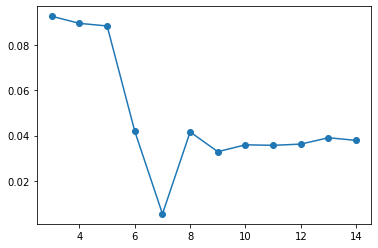

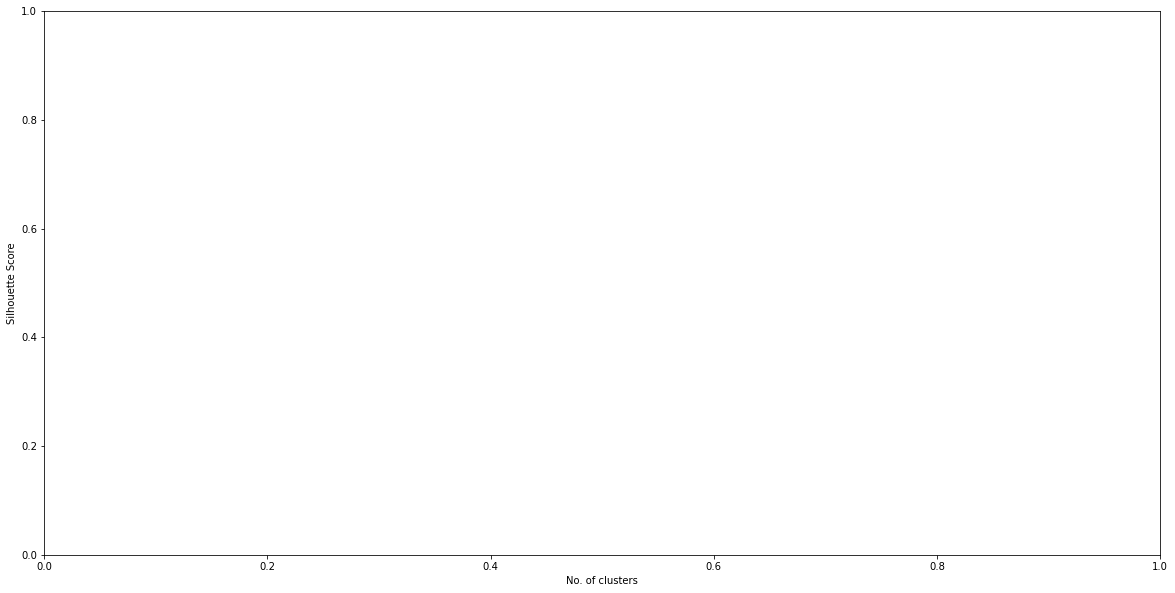

In [57]:
from sklearn.metrics import silhouette_samples, silhouette_score
indices = []
scores = []

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Station_grouped_clustering)
#Station_grouped_clustering = Station_grouped.drop('Station', 1)

for kclusters in range(3, 15) :
    kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit_predict(Station_grouped_clustering)
    score = silhouette_score(Station_grouped_clustering, kmeans)
    indices.append(kclusters)
    scores.append(score)
    
plot(indices, scores,"Silhouette score","Clusters")
optimal_value = np.argmax(scores) + 2

In [43]:
# set number of clusters
kclusters = 5

Station_grouped_clustering = Station_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Station_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 4, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 3, 0, 0, 0, 0, 0, 1])

In [45]:
# add clustering labels
Station_venues_sorted.insert(0, 'Cluster Labels3', kmeans.labels_)

Station_merged = stations


Station_merged = Station_merged.join(Station_venues_sorted.set_index('Station'), on='Station_Name')

Station_merged.head() # check the last columns!

,Latitude,Longitude,Station_Name,Cluster Labels3,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,19.081522,72.841756,Santacruz,1,1,Clothing Store,Indian Restaurant,Ice Cream Shop,Steakhouse,Japanese Restaurant
1,19.069658,72.839894,Khar Road,1,1,Seafood Restaurant,Asian Restaurant,Ice Cream Shop,Food Truck,Modern European Restaurant
2,19.016855,72.859193,Wadala Road,1,1,Café,Fast Food Restaurant,Bookstore,Trail,Basketball Court
3,18.996332,72.830860,Lower Parel,1,1,Indian Restaurant,Coffee Shop,Café,Restaurant,Clothing Store
4,18.934487,72.827307,Churchgate,0,0,Indian Restaurant,Coffee Shop,Café,Fast Food Restaurant,Bakery


In [46]:
# create map
Station_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Station_merged['Latitude'], Station_merged['Longitude'], Station_merged['Station_Name'], Station_merged['Cluster Labels3']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Station_clusters)
       
Station_clusters

## understanding clusters

#### Cluster 1

In [47]:
Station_merged.loc[Station_merged['Cluster Labels3'] == 0, Station_merged.columns[[2] + list(range(5, Station_merged.shape[1]))]]

,Station_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Churchgate,Indian Restaurant,Coffee Shop,Café,Fast Food Restaurant,Bakery
5,Grant Road,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Ice Cream Shop,Restaurant
9,King's Circle,Indian Restaurant,Ice Cream Shop,Snack Place,Café,Dessert Shop
10,Sandhurst Road,Indian Restaurant,Dessert Shop,Café,Convenience Store,Chinese Restaurant
11,Dockyard Road,Chinese Restaurant,Boat or Ferry,Indian Restaurant,Snack Place,Convenience Store
13,Chembur,Indian Restaurant,Seafood Restaurant,Restaurant,Lounge,Café
15,Bandra,Indian Restaurant,Café,Chinese Restaurant,Hookah Bar,Seafood Restaurant
17,Charni Road,Indian Restaurant,Fast Food Restaurant,Juice Bar,Ice Cream Shop,Café
18,Dadar (Central),Indian Restaurant,Fast Food Restaurant,Movie Theater,Coffee Shop,Café
19,Dadar,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Movie Theater,Café


Analysis of cluster 1 shows stations with indian restaurents are the buzzing places

In [48]:
Station_merged.loc[Station_merged['Cluster Labels3'] == 1, Station_merged.columns[[2] + list(range(5, Station_merged.shape[1]))]]

,Station_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Santacruz,Clothing Store,Indian Restaurant,Ice Cream Shop,Steakhouse,Japanese Restaurant
1,Khar Road,Seafood Restaurant,Asian Restaurant,Ice Cream Shop,Food Truck,Modern European Restaurant
2,Wadala Road,Café,Fast Food Restaurant,Bookstore,Trail,Basketball Court
3,Lower Parel,Indian Restaurant,Coffee Shop,Café,Restaurant,Clothing Store
7,Cotton Green,Plaza,Bakery,Snack Place,Furniture / Home Store,Vegetarian / Vegan Restaurant
8,Jogeshwari,Indian Restaurant,Pharmacy,Ice Cream Shop,Bakery,Smoke Shop
12,Reay Road,Zoo,Chinese Restaurant,Snack Place,Furniture / Home Store,Bakery
16,Byculla,Bakery,Indian Restaurant,Pizza Place,Coffee Shop,Zoo
22,Mumbai Central,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Coffee Shop
26,Kurla,Shoe Store,Yoga Studio,Vegetarian / Vegan Restaurant,Bus Station,Café


Analysis of cluster 2 shows stations which are hubs for fast food joints and have a variety of them.

In [49]:
Station_merged.loc[Station_merged['Cluster Labels3'] == 2, Station_merged.columns[[2] + list(range(5, Station_merged.shape[1]))]]

,Station_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Mankhurd,Sports Bar,Coffee Shop,Bus Station,Zoo,Fast Food Restaurant


Analysis of cluster 3 shows a single station with a potential for an indian restaurent.

In [50]:
Station_merged.loc[Station_merged['Cluster Labels3'] == 3, Station_merged.columns[[2] + list(range(5, Station_merged.shape[1]))]]

,Station_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Sewri,Harbor / Marina,Cosmetics Shop,Pool Hall,Record Shop,Department Store


Cluster 4 also showcases a single station with a potential to be shopping hub as it has allied businesses operating as popular venues.

In [51]:
Station_merged.loc[Station_merged['Cluster Labels3'] == 4, Station_merged.columns[[2] + list(range(5, Station_merged.shape[1]))]]

,Station_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
40,Mira Road,Bakery,Convenience Store,Café,Multiplex,Ice Cream Shop


The last cluster yields single station which has the potential to open a fast food restaurent to go along with cafe and multiplex.

### Let us understand the venues around stations in depth

In [52]:
Station_merged.describe()

,Latitude,Longitude,Cluster Labels3,Cluster Labels2
count,56.000000,56.000000,56.000000,56.000000
mean,19.060341,72.860008,0.553571,0.464286
std,0.089729,0.035187,0.784385,0.538155
min,18.934487,72.815826,0.000000,0.000000
25%,18.987195,72.839052,0.000000,0.000000
50%,19.047520,72.848650,0.000000,0.000000
75%,19.113534,72.865533,1.000000,1.000000
max,19.310223,72.956605,4.000000,2.000000


<AxesSubplot:ylabel='Venue Category'>

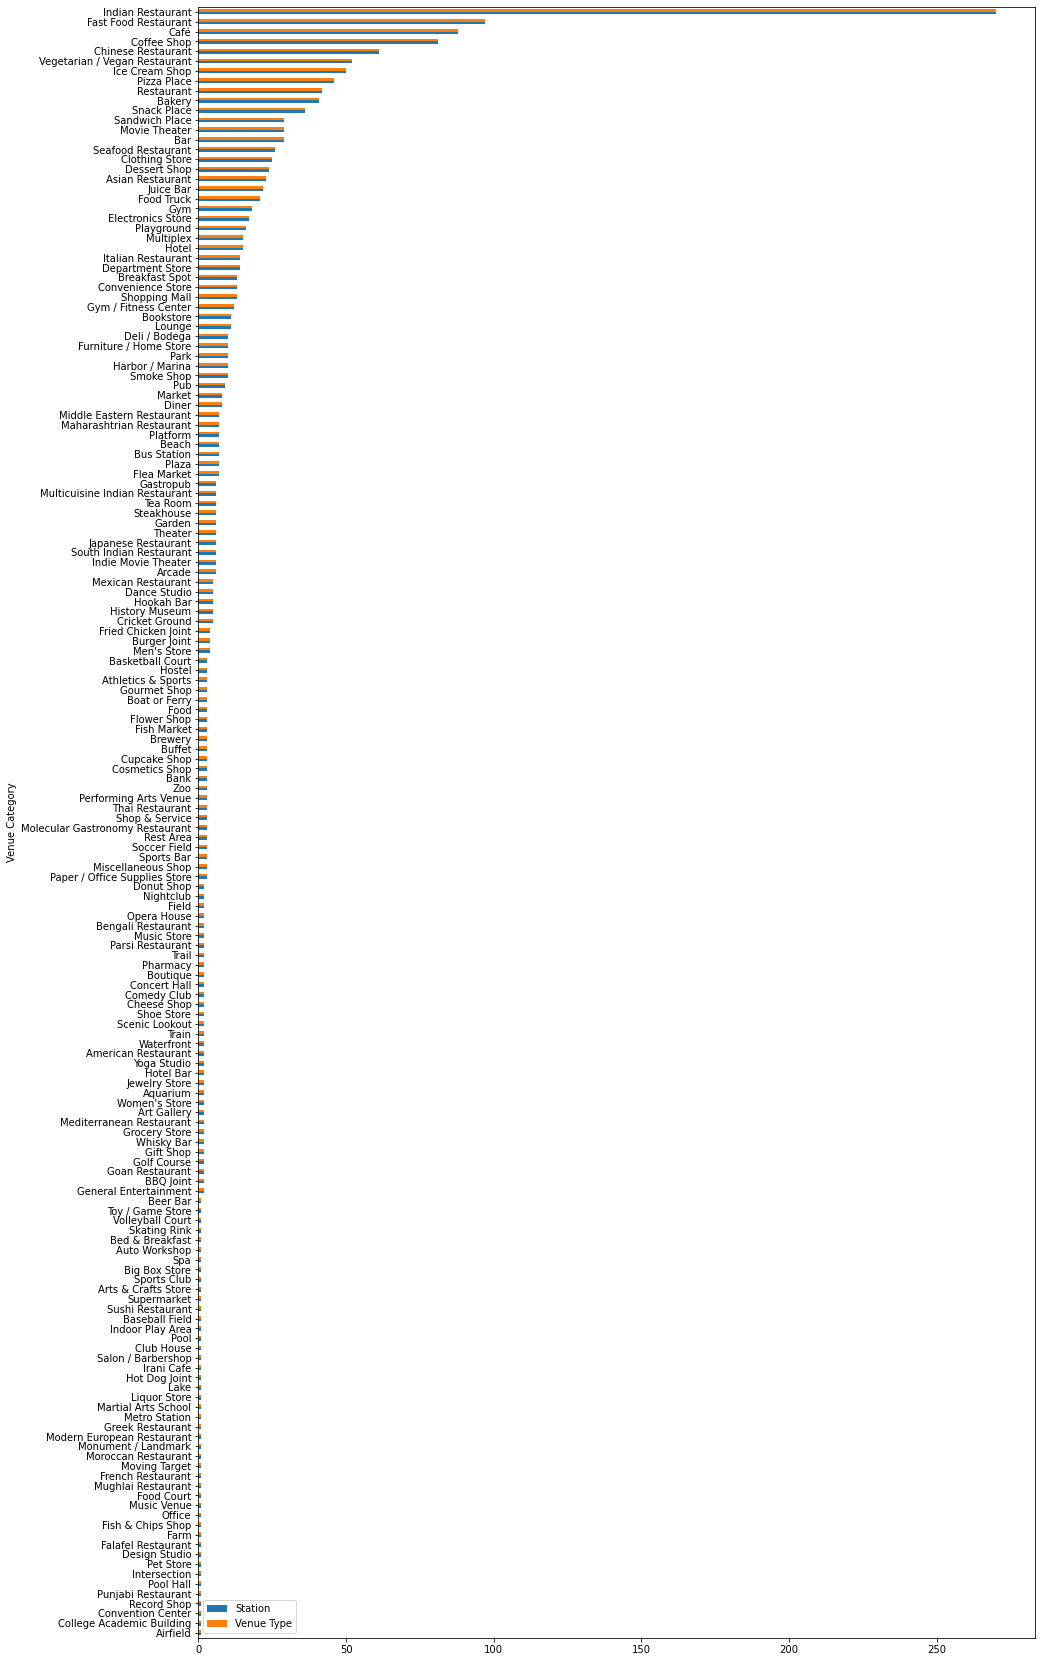

In [61]:
import matplotlib.pyplot as plt

venue = Station_venues.groupby('Venue Category').count()
venue = venue.sort_values(by=['Station'], ascending=True)
venue.drop(venue.columns[[1,2,3,4,5]], axis = 1, inplace = True)
venue.plot.barh(figsize=(15,30))

We can observe that Food joints are the most popular venues near railway stations followed by movie theatres and shopping areas.

<AxesSubplot:ylabel='Station'>

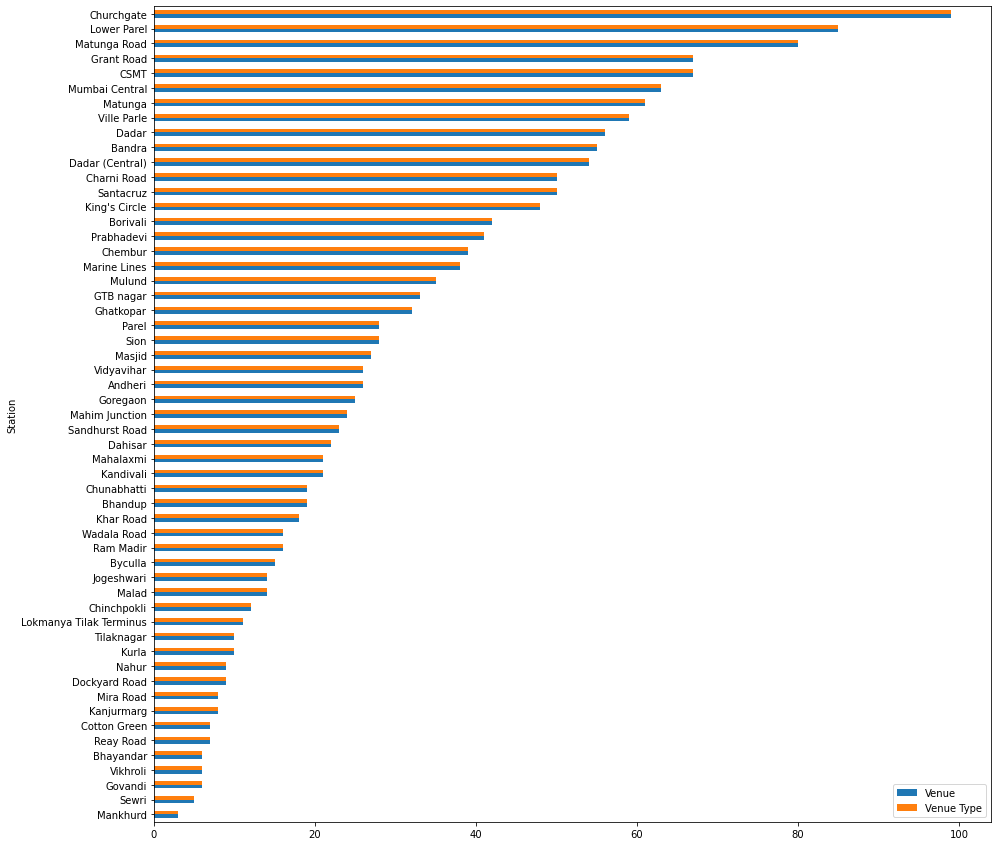

In [62]:
BuzzingStation = Station_venues.groupby('Station').count()
BuzzingStation = BuzzingStation.sort_values(by=['Venue'], ascending=True)
BuzzingStation.drop(BuzzingStation.columns[[0,1,3,4,5]], axis = 1, inplace = True)
BuzzingStation.plot.barh(figsize=(15,15))

Churchgate, Lower Parel and Matunga are the stations with maximum popular venues around them

**Conclusion**


Mumbai with is growing suburbs and metro stations being made in the area, can look at stations with high footfall but low count of popular venues to target them as a business opportunity.
As the food businesses are the most popular businesses, the stations which do not have them as a popular spot pose an opportunity for entreprenures to set up a food business at such stations.

